# Anomalous Mirror Symmetry in python

This notebook implements the steps described in project **Design Your Own 3D Printed Optical Illusion** which can be found at [Science Buddies](https://www.sciencebuddies.org/science-fair-projects/project-ideas/3D-Printing_p003/3D-printing/3d-printed-optical-illusion).  The steps below will construct "impossible" 3D curves as described in the paper [*Anomalous Mirror Symmetry Generated by Optical Illusion*](https://www.mdpi.com/2073-8994/8/4/21/htm) by Dr. Kokichi Sugihara.  

This notebook will allow you to create the 3D objects described in that project and download an STL file that can be opened in CAD software and used to make 3D printed objects. 

If you're viewing this notebook on Google Colab, any changes you make will not be saved unless you click the 'Copy to Drive' button at the top of the window. Doing so will create your own copy in your Google Drive that you can edit. If you're viewing this on github.com, you can [click here](https://githubtocolab.com/markveillette/optical_illusion/blob/main/AnomalousMirrorSymmetry.ipynb) to open the notebook in Google Colab. 

Here is the outline of the notebook (these links won't work if you're on github)

* [Initialize the Notebook](#init)
* [Create 2D curves](#create)
* [Create 3D Anomalous Mirror Symmetry](#make3d)
* [Construct 3D Object](#map3d)
* [Create Edge Vertices](#vertices)
* [Triangularization, Method #1](#met1)
* [Triangularization, Method #2](#met2)
* [Download STL file](#stl)


![plots](plots.png)




# 0. Initialize the notebook <a id="init"></a>

First, run the following cell which defines a number of functions that are used in the rest of the notebook.

In [29]:
#@title Run this cell to define some functions that are used below
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact
from IPython.display import display

def make_curves(name):
  """
  Creates predefined curves of the form 
    {'a1': A1, 'a2': A2}
  where A1 and A2 are [N,2] numpy arrays of x and y coordinates 
  """
  if name=='arrow':
    curves = {'a1': np.array([[-1.  ,  0.  ],
                              [-0.95,  0.5 ],
                              [-0.05,  0.5 ],
                              [ 0.  ,  1.  ],
                              [ 1.  ,  0.  ]]), 
              'a2': np.array([[-1.  ,  0.  ],
                              [-0.95, -0.5 ],
                              [-0.05, -0.5 ],
                              [ 0.  , -1.  ],
                              [ 1.  ,  0.  ]])}
  elif name=='boat':
    data=pd.read_csv('https://raw.githubusercontent.com/markveillette/optical_illusion/main/boat.csv')
    curves = {'a1':data[['x','a1']].values,'a2':data[['x','a2']].values}
  elif name=='car':
    data=pd.read_csv('https://raw.githubusercontent.com/markveillette/optical_illusion/main/car.csv')
    curves = {'a1':data[['x','a1']].values,'a2':data[['x','a2']].values}
  elif name=='fish':
    data=pd.read_csv('https://raw.githubusercontent.com/markveillette/optical_illusion/main/fish.csv')
    curves = {'a1':data[['x','a1']].values,'a2':data[['x','a2']].values}
  else:
    raise RuntimeError('Unknown name %s' % name)
  return update_curves(curves)

def fit_splines(curves,order=1):
  """
  Fits curves to data for a1 and a2.  
  The parameter order controls how smooth the curve fit is,
  Use order=1 to get piecewise linear curves (recommended)
  """
  t1=curves['a1'][:,0]
  t2=curves['a2'][:,0]
  y1=curves['a1'][:,1]
  y2=curves['a2'][:,1]
  # Extend beyond [-1,1] 
  t1_left,t1_right=2*np.min(t1)-t2[1:2],2*np.max(t1)-t2[-2:-1]
  t2_left,t2_right=2*np.min(t2)-t1[1:2],2*np.max(t2)-t1[-2:-1]
  t1,t2=np.concatenate((t1_left,t1,t1_right)),np.concatenate((t2_left,t2,t2_right))
  y1,y2=np.concatenate((y2[1:2],y1,y2[-2:-1])),np.concatenate((y1[1:2],y2,y1[-2:-1]))
  a1s=UnivariateSpline(t1, y1, k=order, s=0)
  a2s=UnivariateSpline(t2, y2, k=order, s=0)
  return a1s,a2s

def update_curves(curves):
  """
  Adds additional points to the a1 and a2 curves to enable the 3D optical 
  illusion. This is created by taking the union of all x-coordiantes of 
  curves a1,a2, and taking their negatives.  
  
  curves is a dict {'a1': np.array,
                    'a2': np.array}
  """
  a1s,a2s=fit_splines(curves,order=1)
  # Make t points symmetric
  a1ts = set(curves['a1'][:,0]).union(set(-curves['a1'][:,0]))
  a2ts = set(curves['a2'][:,0]).union(set(-curves['a2'][:,0]))
  allts = a1ts.union(a2ts)
  # redefine curves
  t=np.sort(np.array(list(allts)))
  a1=a1s(t)
  a2=a2s(t)
  return {'a1': np.stack((t,a1),axis=1),
          'a2': np.stack((t,a2),axis=1)}

def get_vertices(xt,yt,zt,H=1,alpha=1):
  """
  Computes Vertices along edges of 3D shape of height H 
  generated from coordinates xt,yt,zt and alpha.

  Returns a [N,4,3] array of points.  

  """
  xb,yb,zb=xt,yt,zt-H
  # points should odd number of x values (since starting point is repeated)
  assert len(xt) % 2 == 1
  n_points = len(xt)-1
  n_polygons = (len(xt)+1)//2  
  nanpt=[np.nan,np.nan,np.nan]
  polygons=[]
  polygons.append([ [xt[0],yt[0],zt[0]], 
                    nanpt,
                    nanpt,
                    [xb[0],yb[0],zb[0]]
    ])
  polyi=lambda i: [
        [xt[i],yt[i],zt[i]],
        [xt[n_points-i],yt[n_points-i],zt[n_points-i]],
        [xb[n_points-i],yb[n_points-i],zb[n_points-i]],
        [xb[i],yb[i],zb[i]],           
  ]
  polygons+=[polyi(i) for i in range(1,n_polygons-1)]
  polygons.append([ [xt[n_polygons-1],yt[n_polygons-1],zt[n_polygons-1]], 
                    nanpt,
                    nanpt,
                    [xb[n_polygons-1],yb[n_polygons-1],zb[n_polygons-1]]
    ])
  return np.array(polygons)


def create_triangles(P,method='method2'):
  """
  Creates triangularization using method 1 or 2 (see docstrings below)
  """
  if method in ['method1','1',1]:
    return create_triangles_1(P)
  else:
    return create_triangles_2(P)


def create_triangles_1(P):
  """
  Transforms N,4,3 array of vertices to array of
  vertices and indices.  This uses method 1 which
  using vertical triangles on the side walls, 
  triangles going across the top and bottom surfaces to 
  opposite edges. 

  Functions returns
     P:  [M,3] array of triangle coordinates
     T:  [M,3] array of indices into P that make triangles 
  """
  
  # Sort points starting from t=-1
  #  Two points, ordered top-bottom to start
  #  Four points per polygon, ordered top left,top right, bottom right, bottom left
  #  Two points top-bottom to end
  npoly=P.shape[0]
  P = np.reshape(P,(-1,3)) # N,3
  P = P[~np.any(np.isnan(P),axis=1)]
  T=[]
  # This converts multiindex i,j into the [N,4] array
  # of vertices into output triangle index
  ij2k = lambda i,j: 2+4*(i-1)+j 
  # add 6 triangles coming from first line
  # Make sure all triangles are oriented outward 
  # top face
  T.append([0,ij2k(1,1),ij2k(1,0)])
  # right face
  T.append([0,ij2k(1,2),ij2k(1,1)])
  T.append([0,1,ij2k(1,2)])
  # bottom face
  T.append([1,ij2k(1,3),ij2k(1,2)])
  #left face
  T.append([0,ij2k(1,0),ij2k(1,3)])
  T.append([0,ij2k(1,3),1])
  # For each polygon, add 8 triangles
  
  for i in range(1,npoly-2):
    # Top
    T.append([ij2k(i,0),ij2k(i+1,1),ij2k(i+1,0)])
    T.append([ij2k(i,0),ij2k(i,1),ij2k(i+1,1)])
    # Right
    T.append([ij2k(i,1),ij2k(i+1,2),ij2k(i+1,1)])
    T.append([ij2k(i,1),ij2k(i,2),ij2k(i+1,2)])
    # Bottom
    T.append([ij2k(i,2),ij2k(i+1,3),ij2k(i+1,2)])
    T.append([ij2k(i,2),ij2k(i,3),ij2k(i+1,3)])
    # Right
    T.append([ij2k(i,3),ij2k(i+1,0),ij2k(i+1,3)])
    T.append([ij2k(i,3),ij2k(i,0),ij2k(i+1,0)])
  # add 6 triangles going into last line
  i=npoly-2
  npt=P.shape[0]
  # top face
  T.append([npt-2,ij2k(i,0),ij2k(i,1)])
  # right face
  T.append([npt-2,ij2k(i,1),ij2k(i,2)])
  T.append([npt-2,ij2k(i,2),npt-1])
  # bottom face
  T.append([npt-1,ij2k(i,2),ij2k(i,3)])
  #left face
  T.append([npt-2,ij2k(i,3),ij2k(i,0)])
  T.append([npt-2,npt-1,ij2k(i,3)])
  return P, np.array(T)
    
def create_triangles_2(P):
  """
  Transforms N,4,3 array of vertices to array of
  vertices and indices.  This uses method 2 which
  creates points at the center of the object.
  

  Functions returns
     P:  [M,3] array of triangle coordinates
     T:  [M,3] array of indices into P that make triangles 
  """
  
  # Sort points starting from x=-1
  #  Two points, ordered top-bottom to start
  #  Four points per polygon, ordered top left,top right,bottom right,bottom left
  #  To points top-bottom to end
  npoly=P.shape[0]
  meanz = 0.5*(np.nanmean(P[:,0,2]+P[:,1,2]))
  P = np.reshape(P,(-1,3)) # N,3
  P = P[~np.any(np.isnan(P),axis=1)]
  H=np.abs(P[0][2]-P[1][2])
  ztop,zbot=meanz,meanz-H
  CTOP_K=P.shape[0]
  CBOT_K=P.shape[0]+1 
  T=[]
  #ij2k = lambda i,j: 2+4*(i-1)+j
  npt=P.shape[0]
  # This converts multiindex i,j into the [N,4] array
  # of vertices into output triangle index
  def ij2k(i,j): 
    if i==0:
      return {0:0,1:0,2:1,3:1}[j]
    elif i==npoly-1:
      return {0:npt-2,1:npt-2,2:npt-1,3:npt-1}[j]
    else:
      return 2+4*(i-1)+j

  for i in range(npoly-1):
    # add 8 triangles coming from first line
    # Top
    T.append([ij2k(i,0),CTOP_K,ij2k(i+1,0)])
    T.append([ij2k(i,1),ij2k(i+1,1),CTOP_K])
    # Right
    T.append([ij2k(i,1),ij2k(i+1,2),ij2k(i+1,1)])
    T.append([ij2k(i,1),ij2k(i,2),ij2k(i+1,2)])
    # Bottom
    T.append([ij2k(i,2),CBOT_K,ij2k(i+1,2)])
    T.append([ij2k(i,3),ij2k(i+1,3),CBOT_K])
    # Right
    T.append([ij2k(i,3),ij2k(i+1,0),ij2k(i+1,3)])
    T.append([ij2k(i,3),ij2k(i,0),ij2k(i+1,0)])
  # Add two additional points for center
  P = np.vstack( (P,[[0,0,ztop]],[[0,0,zbot]]))
  return P, np.array(T)


# 1.  Create the Curve in 2D <a id="create"></a>

Start by creating the shape in 2D.  This is done by defining two functions called $a_1(x)$ and $a_2(x)$ that make the "top" and "bottom" of the curve.

Run the cell below, then select a predefined shape from the pulldown menu.  This will automatically create these two curves for the shape you select.

Or, if you prefer to enter your own curve, skip to the cell labeled "Manually enter your own curve".

In [2]:
#@title Run this cell before using pulldown menu
import ipywidgets as widgets

OPTIONS=['arrow','boat','car','fish']
menu = widgets.Dropdown(
       options=OPTIONS,
       description='Shape:')
curves=make_curves(OPTIONS[0]) 
def on_change(change):
    global curves
    if change['type'] == 'change' and change['name'] == 'label':
        curves=make_curves(change['new'])
menu.observe(on_change)
display(menu)


Dropdown(description='Shape:', options=('arrow', 'boat', 'car', 'fish'), value='arrow')

Or alternatively,  uncomment the next cell and manually enter data for the curves $(x,a_1(x))$ and $(x,a_2(x))$.

The first point of each curve should be (-1,0), and the last point should be (1,0).  Also, the x-values in each curve should be strictly increasing.

In [20]:
# [OPTIONAL] Manually enter your own curves and run this cell.  
#.           If you enter your own curve, remove the lines with """
"""
curves = {
    'a1' : [ [-1,0], 
             <enter data here>
             [1,0]
    ],
    'a2' : [ [-1,0], 
             <enter data here>
             [1,0]
    ],
}
curves=update_curves(curves)
"""
pass

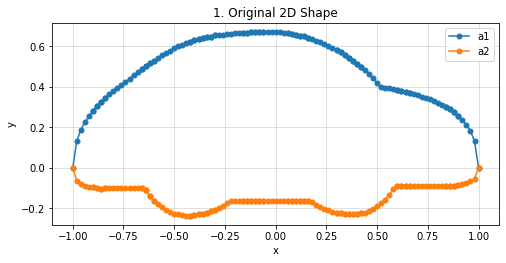

In [21]:
# Plot your curves in 2D.
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.plot(curves['a1'][:,0],curves['a1'][:,1],'.-',markersize=10,label='a1')
ax.plot(curves['a2'][:,0],curves['a2'][:,1],'.-',markersize=10,label='a2')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('1. Original 2D Shape')
ax.set_aspect('equal')
ax.grid(True,alpha=0.5)
plt.legend()

# NOTE:  If you entered your own curve, you may see "extra" points in the plot.  
# These were added to enable the 3D illusion later on. 

## 2. Create 3D Anomalous Mirror Symmetry <a id="make3d"></a>

As described in [*Anomalous Mirror Symmetry Generated by Optical Illusion*](https://www.mdpi.com/2073-8994/8/4/21/htm), the following equations transform the curves $a_1$ and $a_2$ into a closed 3D curve that exhibits anomalous mirror symmetry.  We can parameterize the two halves of this 3D curve as functions of $x$ values between -1 and 1:

$c_1(x) = \left(x, \frac{1}{2}[a_1(x)-a_2(-x)],\frac{\alpha}{2}[a_1(x)+a_2(-x)] \right), \ \ \ -1 \leq x \leq 1$

$c_2(x) = \left(t, \frac{1}{2}[a_2(x)-a_1(-x)],\frac{\alpha}{2}[a_2(x)+a_1(-x)] \right), \ \ \ -1 \leq x \leq 1$

The constant $\alpha$ is the tangent of the view angle.  Setting $\alpha=1$ means the symmetry will happen when viewed at a 45 degree angle.

Run this cell to create the functions $c_1$ and $c_2$ that will be used to trace this curve in 3D. 


In [22]:
alpha=1 # alpha=tan( view angle that generates anomalous symmetry )

a1s,a2s=fit_splines(curves,order=1) # piecewise-linear fit to a1,2
c1 = lambda x:  np.stack( 
                          ( x.T,
                            0.5*(a1s(x)-a2s(-x)).T,
                            alpha*0.5*(a1s(x)+a2s(-x)).T
                          ), axis=1 )
c2 = lambda x:  np.stack( 
                          ( x.T,
                            0.5*(a2s(x)-a1s(-x)).T,
                            alpha*0.5*(a2s(x)+a1s(-x)).T
                          ), axis=1 )


The next cell generates an interactive 3D plot of your curve.  Click and drag on the 3D plot to rotate it. Can you rotate it to the correct angle to see the outline of the original 2D shape? What happens if you spin the shape 180 degrees about the z-axis?

In [23]:
t1,t2=curves['a1'][:-1,0],np.flip(curves['a2'][:,0])
cxyz1,cxyz2=c1(t1),c2(t2)
x=np.concatenate( (cxyz1[:,0],cxyz2[:,0]) )
y=np.concatenate( (cxyz1[:,1],cxyz2[:,1]) )
z=np.concatenate( (cxyz1[:,2],cxyz2[:,2]) )

fig = make_subplots(specs=[[{}]])
fig.add_trace( go.Scatter3d(x=x,y=y,z=z,mode='lines',line={'width':6}) )

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=1.25, z=1.25)
)

fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[-1.5,1.5],),
        yaxis = dict(nticks=4, range=[-1.5,1.5],),
        zaxis = dict(nticks=4, range=[-1.5,1.5],),
        ),
    scene_camera=camera,
    width=700,
    margin=dict(r=20, l=20, b=20, t=20))
fig


## 3. Map to 3D object <a name="map3d"></a>

To create a 3D object out of this curve, we start by duplicating the curve at a distance $H$ below the curve defined above.  Rotate this around and confirm that the illusion still works (you may need to adjust `H`).

In [24]:
H=0.5
x1,y1,z1=x,y,z-H

fig = make_subplots(specs=[[{}]])
fig.add_trace( go.Scatter3d(x=x,y=y,z=z,mode='lines',line={'width':6},name='Top'))
fig.add_trace( go.Scatter3d(x=x1,y=y1,z=z1,mode='lines',line={'width':6},name='Bottom') )

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=1.25, z=.6)
)

fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[-1.5,1.5],),
        yaxis = dict(nticks=4, range=[-1.5,1.5],),
        zaxis = dict(nticks=4, range=[-1.5,1.5],),
        ),
    width=700,
    scene_camera=camera,
    margin=dict(r=20, l=20, b=20, t=20))
fig


## 4. Find Vertices <a id="vertices"></a>

Next, we identify vertices around the border of this 3D shape that will be used to create a triangularization.   

Text(0.5, 0, 'z-axis')

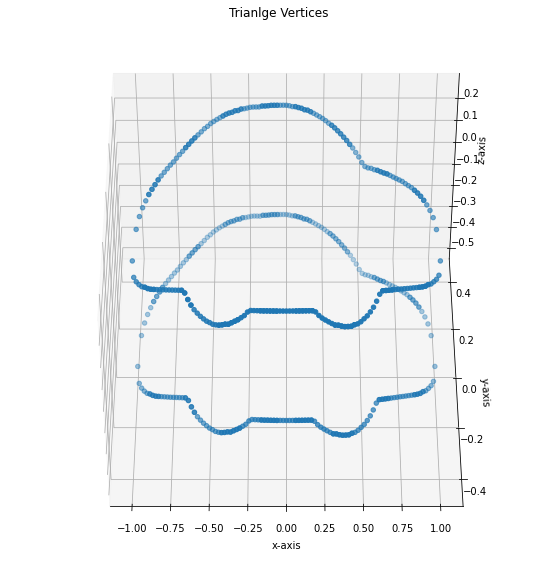

In [25]:
# To see details see function definition at top of the notebook
vertices = get_vertices(x,y,z,H,alpha)
xv=vertices[:,:,0].flatten()
yv=vertices[:,:,1].flatten()
zv=vertices[:,:,2].flatten()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(xv,yv,zv, '.-')
ax.view_init(elev=np.arctan(alpha)*180/np.pi, azim=270)
ax.set_title('Trianlge Vertices')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')


## 5.  Generate Triangularization (method #1) <a class="anchor" id="met1"></a>

This generates a triangularization using vertical triangles on the side walls, triangles going across the top and bottom surfaces to opposite edges.   Details are in the function `create_triangles_1`.

This cell visualizes the 3D object with this triangularization.

In [26]:
P,T=create_triangles(vertices,method=1)

@interact(rotation=(90-180,90+180))
def plot3D(rotation):
    fig=plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(P[T])
    mesh.set_edgecolor([.7,.7,.7,.3])
    ax.add_collection3d(mesh)
    ax.set_xlabel("x-axis")
    ax.set_ylabel("y-axis")
    ax.set_zlabel("z-axis")

    ax.view_init(elev=45, azim=rotation)
    ax.set_xlim(-1.5,1.5)  
    ax.set_ylim(-1.5,1.5)  
    ax.set_zlim(-1.5,1.5)  
    plt.show()



interactive(children=(IntSlider(value=90, description='rotation', max=270, min=-90), Output()), _dom_classes=(…

## 6.  Generate Triangularization (method #2) <a name="met2"></a>

Instead of making triangles go across to opposite edges of
 the top and bottom of the shape, we will add two more points in the
 center of the top and bottom, and make triangles that connect to these
 points.  Details are in the function `create_triangles_2`.

This cell visualizes the 3D object using method 2.

In [30]:
P,T=create_triangles(vertices,method=2)

@interact(rotation=(90-180,90+180))
def plot3D(rotation):
  fig=plt.figure(figsize=(10,10))
  ax = fig.add_subplot(111, projection='3d')
  mesh = Poly3DCollection(P[T])
  mesh.set_edgecolor([.7,.7,.7,.3])
  ax.add_collection3d(mesh)
  ax.set_xlabel("x-axis")
  ax.set_ylabel("y-axis")
  ax.set_zlabel("z-axis")

  ax.view_init(elev=45, azim=rotation)
  ax.set_xlim(-1.5,1.5)  
  ax.set_ylim(-1.5,1.5)  
  ax.set_zlim(-1.5,1.5)  
  plt.show()

interactive(children=(IntSlider(value=90, description='rotation', max=270, min=-90), Output()), _dom_classes=(…

## Create STL files<a name="stl"></a>

The following cells will create and download an STL file for 3D printing of this object.  

The first cell below installs the `numpy-stl` package, and the next cell creates and downloads an STL file.  You can choose between the two methods described above by setting `method` to be 1 or 2.  Method 2 tends to look a little better overall, but doesn't work for all curves. 

In [11]:
!pip install numpy-stl

In [32]:
# Generate and download STL file 
from stl import mesh


method=2 # choose 1 or 2, whichever looks better.
P,T=create_triangles(vertices,method=method)
triangles=P[T]
data = np.zeros(triangles.shape[0], dtype=mesh.Mesh.dtype)
for i,tri in enumerate(triangles):
  data['vectors'][i] = tri
my_mesh=mesh.Mesh(data.copy()) 

fname='anomalous_%s_method_%d.stl' % (menu.value,method)
my_mesh.save(fname)

# If running on google colab, download file
try:
    from google.colab import files
    files.download(fname)
except ImportError:
    pass

